# Sleep Prediction

In this notebook we attempt to predict the specific timesteps for both sleep onsets and wakeup for each user on every night.

Much of the code in this notebook was taken and refactored to pandas from this original [notebook](https://www.kaggle.com/code/zhukovoleksiy/detect-sleep-states-baseline-solution/notebook). 

# Import Data

In [1]:
# clear memory
import gc
gc.collect()
%reset -f

In [2]:
# helper.py
from helper import *

# score function
from metric import score

In [3]:
# load data
data = pl.read_parquet(root + 'train_series_clean.parquet')
events = pl.read_csv(root + 'train_events.csv')
test = pl.read_parquet(root + 'test_series_clean.parquet')

# show number of unique series
print('Number of unique series:', data['series_id'].n_unique())

Number of unique series: 277


# Split Data

In [11]:
# get train and val subsets (28 users = 10% subset of 277 users)
data_train, data_val, events_train, events_val = train_val_split(series=data, events=events, n=28)

# check number of users in each subset
print(f'Train data series_ids: {data_train["series_id"].n_unique()}')
print(f'Val data series_ids: {data_val["series_id"].n_unique()}')

Train data series_ids: 22
Val data series_ids: 6


# Feature Engineering

In [12]:
# create features
features_train = create_features(data_train)
features_val = create_features(data_val)

# define cols to be normalized
non_norm_cols = ['series_id', 'step', 'date', 'day', 'asleep', 'hour']
norm_cols = [col for col in features_train.columns if col not in non_norm_cols]

# compute mean and std for each column as dictionaries
mean_dict = features_train.select(norm_cols).mean().to_dicts()[0]
std_dict = features_train.select(norm_cols).std().to_dicts()[0]

# normalize
features_train = features_train.with_columns([((pl.col(col) - mean_dict[col]) / std_dict[col]).cast(pl.Float32) for col in norm_cols])
features_val = features_val.with_columns([((pl.col(col) - mean_dict[col]) / std_dict[col]).cast(pl.Float32) for col in norm_cols])

# check
features_train.sample()

Iterating through windows: 100%|██████████| 15/15 [00:00<00:00, 5000.36it/s]


series_id,step,anglez,enmo,date,hour,anglez_diff,enmo_diff,day,asleep,enmo_1m_mean,enmo_1m_max,enmo_1m_min,enmo_1m_std,enmo_diff_1m_mean,enmo_diff_1m_max,enmo_diff_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_min,anglez_1m_std,anglez_diff_1m_mean,anglez_diff_1m_max,anglez_diff_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_min,enmo_3m_std,enmo_diff_3m_mean,enmo_diff_3m_max,enmo_diff_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_min,anglez_3m_std,anglez_diff_3m_mean,anglez_diff_3m_max,anglez_diff_3m_std,enmo_5m_mean,enmo_5m_max,enmo_5m_min,enmo_5m_std,enmo_diff_5m_mean,enmo_diff_5m_max,enmo_diff_5m_std,anglez_5m_mean,anglez_5m_max,anglez_5m_min,anglez_5m_std,anglez_diff_5m_mean,anglez_diff_5m_max,anglez_diff_5m_std,enmo_7.5m_mean,enmo_7.5m_max,enmo_7.5m_min,enmo_7.5m_std,enmo_diff_7.5m_mean,enmo_diff_7.5m_max,enmo_diff_7.5m_std,anglez_7.5m_mean,anglez_7.5m_max,anglez_7.5m_min,anglez_7.5m_std,anglez_diff_7.5m_mean,anglez_diff_7.5m_max,anglez_diff_7.5m_std,enmo_10m_mean,enmo_10m_max,enmo_10m_min,enmo_10m_std,enmo_diff_10m_mean,enmo_diff_10m_max,enmo_diff_10m_std,anglez_10m_mean,anglez_10m_max,anglez_10m_min,anglez_10m_std,anglez_diff_10m_mean,anglez_diff_10m_max,anglez_diff_10m_std,enmo_12.5m_mean,enmo_12.5m_max,enmo_12.5m_min,enmo_12.5m_std,enmo_diff_12.5m_mean,enmo_diff_12.5m_max,enmo_diff_12.5m_std,anglez_12.5m_mean,anglez_12.5m_max,anglez_12.5m_min,anglez_12.5m_std,anglez_diff_12.5m_mean,anglez_diff_12.5m_max,anglez_diff_12.5m_std,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diff_15m_mean,enmo_diff_15m_max,enmo_diff_15m_std,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diff_15m_mean,anglez_diff_15m_max,anglez_diff_15m_std,enmo_20m_mean,enmo_20m_max,enmo_20m_min,enmo_20m_std,enmo_diff_20m_mean,enmo_diff_20m_max,enmo_diff_20m_std,anglez_20m_mean,anglez_20m_max,anglez_20m_min,anglez_20m_std,anglez_diff_20m_mean,anglez_diff_20m_max,anglez_diff_20m_std,enmo_25m_mean,enmo_25m_max,enmo_25m_min,enmo_25m_std,enmo_diff_25m_mean,enmo_diff_25m_max,enmo_diff_25m_std,anglez_25m_mean,anglez_25m_max,anglez_25m_min,anglez_25m_std,anglez_diff_25m_mean,anglez_diff_25m_max,anglez_diff_25m_std,enmo_30m_mean,enmo_30m_max,enmo_30m_min,enmo_30m_std,enmo_diff_30m_mean,enmo_diff_30m_max,enmo_diff_30m_std,anglez_30m_mean,anglez_30m_max,anglez_30m_min,anglez_30m_std,anglez_diff_30m_mean,anglez_diff_30m_max,anglez_diff_30m_std,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diff_60m_mean,enmo_diff_60m_max,enmo_diff_60m_std,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diff_60m_mean,anglez_diff_60m_max,anglez_diff_60m_std,enmo_120m_mean,enmo_120m_max,enmo_120m_min,enmo_120m_std,enmo_diff_120m_mean,enmo_diff_120m_max,enmo_diff_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_min,anglez_120m_std,anglez_diff_120m_mean,anglez_diff_120m_max,anglez_diff_120m_std,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diff_180m_mean,enmo_diff_180m_max,enmo_diff_180m_std,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diff_180m_mean,anglez_diff_180m_max,anglez_diff_180m_std,enmo_240m_mean,enmo_240m_max,enmo_240m_min,enmo_240m_std,enmo_diff_240m_mean,enmo_diff_240m_max,enmo_diff_240m_std,anglez_240m_mean,anglez_240m_max,anglez_240m_min,anglez_240m_std,anglez_diff_240m_mean,anglez_diff_240m_max,anglez_diff_240m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diff_480m_mean,enmo_diff_480m_max,enmo_diff_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diff_480m_mean,anglez_diff_480m_max,anglez_diff_480m_std
str,u32,f32,f32,date,i8,f32,f32,i32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32

- 5 non-feature columns ('series_id', 'step', 'date', 'day', 'asleep').
- 214 normalized features + hour of day (215 features total).

In [13]:
# define non-feature cols
non_feat_cols = ['series_id', 'step', 'date', 'day', 'asleep']

# define x and y
X_train = features_train.drop(non_feat_cols)
y_train = features_train.select("asleep").to_numpy().ravel()
X_val = features_val.drop(non_feat_cols)
y_val = features_val.select("asleep").to_numpy().ravel()

# check shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (9574200, 215)
y_train shape: (9574200,)
X_val shape: (2551500, 215)
y_val shape: (2551500,)


# XGBoost on 10% Subset

              precision    recall  f1-score   support

       False       0.99      0.95      0.97   1884036
        True       0.88      0.97      0.92    667464

    accuracy                           0.96   2551500
   macro avg       0.94      0.96      0.95   2551500
weighted avg       0.96      0.96      0.96   2551500



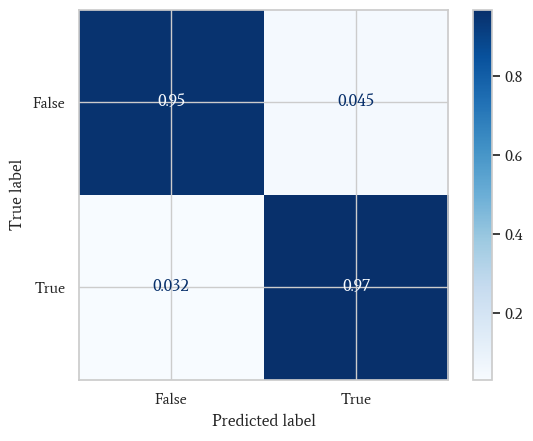

In [16]:
# create xgb and fit
xgb = XGBClassifier(random_state=SEED, n_jobs=-1)
xgb.fit(X_train, y_train)

# get train and val preds
train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)

# validation performance
print(classification_report(y_val, val_preds))
ConfusionMatrixDisplay.from_predictions(y_val, val_preds, normalize='true', cmap='Blues');

- Got about __96% accuracy on the 10% subset__ using a base XGBoost model.

# XGBoost on All Data

In [4]:
# define non-feature cols
non_feat_cols = ['series_id', 'step', 'date', 'day', 'asleep']
xgb = XGBClassifier(random_state=SEED, device='cuda')

In [5]:
def batch_data(data, batch_size=10_000_000):
    """
    Create batches of data for training.

    Args:
    - data (pl.DataFrame): Data to be batched.
    - batch_size (int): Size of each batch. Default is 10 million.

    Returns:
    - (generator): Yields batches of data.
    """

    # iterate through batches
    for i in range(0, len(data), batch_size):
        # get batch
        batch = data[i:i + batch_size]

        # create features
        features = create_features(batch)

        # define cols to be normalized
        non_norm_cols = ['series_id', 'step', 'date', 'day', 'asleep', 'hour']
        norm_cols = [col for col in features.columns if col not in non_norm_cols]

        # compute mean & std, convert to dictionaries
        mean_dict = features.select(norm_cols).mean().to_dicts()[0]
        std_dict = features.select(norm_cols).std().to_dicts()[0]

        # normalize
        features_norm = features.with_columns([((pl.col(col) - mean_dict[col]) / std_dict[col]).cast(pl.Float32) for col in norm_cols])

        # generate normalized features from the batch
        yield features_norm

In [ ]:
# iterate through batches
for i, features in enumerate(batch_data(data)):
    # define x and y
    X_batch = features.drop(non_feat_cols)
    y_batch = features.select("asleep").to_numpy().ravel()

    if i == 0:
        # for the first batch, train normally
        xgb.fit(X_batch, y_batch)
    else:
        # continue training using the current booster
        xgb.fit(X_batch, y_batch, xgb_model=xgb.get_booster())

# save model weights
xgb.save_model('xgb_model.json')

Iterating through windows: 100%|██████████| 15/15 [00:00<00:00, 1299.86it/s]


In [ ]:
# save model weights
xgb.save_model('xgb_model.json')

In [ ]:
# load model weights
xgb = XGBClassifier(random_state=SEED, n_jobs=-1)
xgb.load_model('xgb_model.json')

In [ ]:
def predict(data, classifier):
    """
    Takes a time series of (containing features and labels) and a classifier and returns a formatted submission dataframe.

    Args:
    - data (pl.DataFrame): Contains series data and sleep events.
    - classifier (sklearn.classifier): Trained classifier for prediction.

    Returns:
    - event_preds_df (pd.DataFrame): Contains predicted sleep events.
    """
    
    # non-feature columns
    non_feat_cols = ['series_id', 'step', 'date']

    # get unique series_ids as a list
    series_ids = data.select("series_id").unique().to_series().to_list()

    # list to accumulate event predictions
    event_preds = []

    # iterate through series_ids
    for sid in series_ids:
        # filter the data for the current series id
        user_data = data.filter(pl.col("series_id") == sid)

        # create features
        features = create_features(user_data)

        # define cols to be normalized
        non_norm_cols = ['series_id', 'step', 'date', 'day', 'asleep', 'hour']
        norm_cols = [col for col in features.columns if col not in non_norm_cols]

        # compute mean & std, convert to dictionaries
        mean_dict = features.select(norm_cols).mean().to_dicts()[0]
        std_dict = features.select(norm_cols).std().to_dicts()[0]

        # normalize
        features_norm = features.with_columns([((pl.col(col) - mean_dict[col]) / std_dict[col]).cast(pl.Float32) for col in norm_cols])

        # define x and y
        X = features.drop(non_feat_cols)
        y = features.select("asleep").to_numpy().ravel()

        # get preds
        preds = classifier.predict(X.drop(non_feat_cols))
        probs = classifier.predict_proba(X.drop(non_feat_cols))[:, 1]
        
        # append predictions to X
        X = X.with_columns([pl.Series("pred", preds), pl.Series("prob", probs)])
        
        # calculate the difference in predictions to find changes
        X = X.with_columns(pl.col("pred").diff().alias("pred_diff"))
        
        # extract the 'step' values where the change indicates an onset (0 -> 1) or wakeup (1 -> 0)
        pred_onsets = X.filter(pl.col("pred_diff") > 0)["step"].to_list()
        pred_wakeups = X.filter(pl.col("pred_diff") < 0)["step"].to_list()
        
        # process events if we have at least one onset and wakeup
        if len(pred_onsets) > 0 and len(pred_wakeups) > 0:
            # if first wakeup occurs before the first onset, drop it
            if pred_wakeups[0] < pred_onsets[0]:
                pred_wakeups = pred_wakeups[1:]
            # if last onset occurs after the last wakeup, drop it
            if pred_onsets and pred_wakeups and pred_onsets[-1] > pred_wakeups[-1]:
                pred_onsets = pred_onsets[:-1]
            
            # create sleep periods only if the duration is at least 120 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if (wakeup - onset) >= (120 * 12)]
            
            # iterate through sleep periods
            for onset, wakeup in sleep_periods:
                # compute the average probability score
                sleep_segment = X.filter((pl.col("step") >= onset) & (pl.col("step") < wakeup))
                score = sleep_segment.select(pl.col("prob")).mean().item()
                
                # get onset and wakeup dates
                onset_date = X.filter(pl.col("step") == onset).select(pl.col("date")).to_series()[0]
                wakeup_date = X.filter(pl.col("step") == wakeup).select(pl.col("date")).to_series()[0]
                
                # append the events to the list
                event_preds.append({"series_id": sid, "step": onset, "event": "onset", "score": score, "date": onset_date})
                event_preds.append({"series_id": sid, "step": wakeup, "event": "wakeup", "score": score, "date": wakeup_date})

    # create a pandas df for the preds
    event_preds_df = pd.DataFrame(event_preds)

    # add 'row_id' col
    event_preds_df['row_id'] = range(len(event_preds_df))

    return event_preds_df

In [33]:
# get predictions
preds = predict(data, xgb)

# get labels for validation set
labels = events.filter(pl.col('series_id').is_in(data.select(pl.col('series_id')).unique())).select(['series_id', 'step', 'event']).to_pandas()

# args for scoring function
tolerance_values = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
tolerances = {"onset": tolerance_values, "wakeup": tolerance_values}

# get score
final_score = score(solution=events.select(['series_id', 'step', 'event']).to_pandas(), submission=preds, tolerances=tolerances, 
      series_id_column_name='series_id', time_column_name='step', event_column_name='event', score_column_name='score')

# check score
final_score

Iterating through series_ids:   0%|          | 0/277 [00:00<?, ?it/s]


ValueError: Feature shape mismatch, expected: 5, got 215

In [ ]:
preds.shape

IndexError: single positional indexer is out-of-bounds

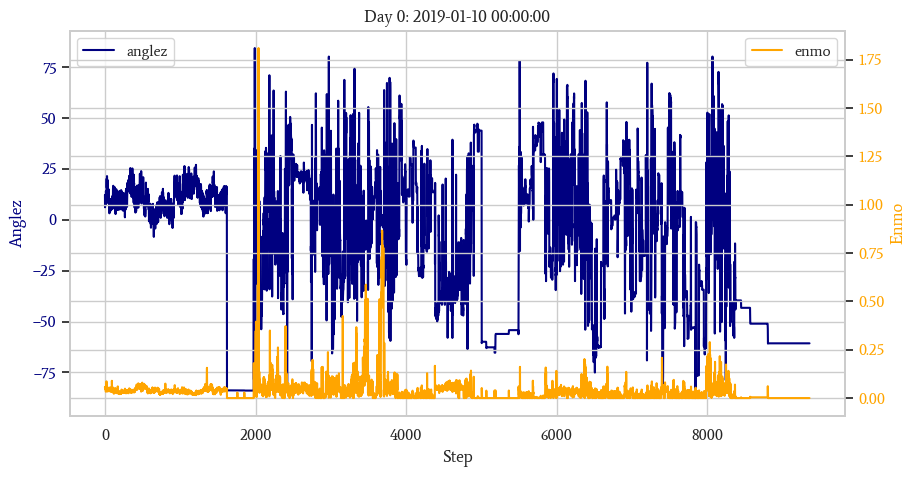

In [26]:
# get a random user
user_id = get_random_id(data)

# get data, preds, and events for the user
user_data = data.filter(pl.col('series_id') == user_id)
user_preds = preds.query('series_id == @user_id')
user_events = events.filter(pl.col('series_id') == user_id)

# plot preds
plot_preds(user_data, user_preds, user_events)

- We can see that the model had a propensity to predict many onset, wakeup pairs in individual nights. The competition page states that "The longest sleep window during the night is the only one which is recorded". Thus, these predictions will be pruned in the [predict](helper.py) function.
- Now, we'll use the [score](metric.py) function to see how the predictions score for different time thresholds.

# Submission

In [ ]:
# create features for test set
X_test = create_features(test)

# fit scaler
scaler = StandardScaler()
scaler.fit(X_test[norm_cols])

# normalize features


# get predictions
preds = predict(X_test.drop(non_norm_cols[:-1]), xgb)

In [ ]:

submission.drop('date', axis=1).to_csv('submission.csv', index=False)